In [1]:
# %pip install pandas matplotlib
# %pip install networkx

## Plan

1. Extract busts (rajadas) of requests by edge

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def filter_interval(df: pd.DataFrame, start_date = None, minutes = 60):
    if start_date is None:
        start_date = df['timestamp'].min()
    end_date = start_date + pd.Timedelta(minutes=minutes)
    return df.loc[df['timestamp'].between(start_date, end_date)]

def plot_interval(df, start_date, interval, y):
    end_date = start_date + pd.Timedelta(minutes=interval)
    df.loc[df['timestamp'].between(start_date, end_date)].plot.scatter(x = 'timestamp', y=y, )


In [4]:
def group_by_timestamp(df: pd.DataFrame, column: str)-> pd.DataFrame:
    result = {}

    for _, row in df.iterrows():
        ts = row['timestamp']
        edge = row['edge']
        value = row[column]

        key = f"{edge}:{ts}"
        if key not in result:
            result[key] = {
                'edge': edge,
                'timestamp': ts,
                'values': []
            }

        result[key]['values'].append(value)
    result

    df = pd.DataFrame([v for k,v in result.items()])
    return df 

In [5]:
def plot_edges(df:pd.DataFrame):
    import matplotlib.pyplot as plt
    import networkx as nx

    # Create an empty directed graph
    G = nx.DiGraph()

    for edge in df['edge'].unique():
        [client, server] = edge.split('-')
        G.add_edge(client, server)

    # Draw the graph using Matplotlib's pyplot
    nx.draw(G, with_labels=True)
    plt.show()

In [6]:
import numpy as np
def group_by_timestamp(df: pd.DataFrame) -> pd.DataFrame:
    result = []

    counter = 0
    
    tmp_ts = []
    tmp_values = []

    for _, row in df.iterrows():
        ts = row['timestamp']
        value = row['bitrate']
        tmp_ts.append(ts)
        tmp_values.append(value)
        if counter == 15:
            result.append({
                'timestamp': np.array(tmp_ts).min(),
                'values': np.array(tmp_values)
            })
            # reset counter
            counter = 0
            tmp_ts = []
            tmp_values = []
        counter +=1
    df = pd.DataFrame(result)
    return df


## Bitrate

### Pre-processing

In [7]:
df_bitrate = pd.read_csv('dataset/bitrate_train.csv')

In [8]:
df_bitrate.describe()

,timestamp,bitrate
count,1.590300e+05,159030.000000
mean,1.717918e+09,320651.513991
std,1.167365e+05,134394.514009
min,1.717719e+09,270.000000
25%,1.717818e+09,300583.000000
50%,1.717917e+09,354960.000000
75%,1.718017e+09,401571.000000
max,1.718213e+09,638686.000000


In [9]:
df_bitrate.head()

,client,server,timestamp,bitrate
0,ba,ce,1717718915,3000
1,ba,ce,1717718916,66910
2,ba,ce,1717718916,294878
3,ba,ce,1717718916,351151
4,ba,ce,1717718916,329464


In [10]:
# assuming the timestamp is in seconds
df_bitrate['timestamp'] = pd.to_datetime(df_bitrate['timestamp'], unit='s')
df_bitrate.index = df_bitrate['timestamp']
df_bitrate.sort_index(inplace=True)
df_bitrate.head()

,client,server,timestamp,bitrate
timestamp,,,,
2024-06-07 00:02:35,ba,df,2024-06-07 00:02:35,3000
2024-06-07 00:02:36,rj,df,2024-06-07 00:02:36,323984
2024-06-07 00:02:36,ba,df,2024-06-07 00:02:36,347367
2024-06-07 00:02:36,ba,df,2024-06-07 00:02:36,327273
2024-06-07 00:02:36,ba,df,2024-06-07 00:02:36,413041


In [11]:
print(f'star at: {df_bitrate.index.min()}')
print(f'end at: {df_bitrate.index.max()}')

star at: 2024-06-07 00:02:35
end at: 2024-06-12 17:23:37


In [12]:
df_bitrate['edge'] = (df_bitrate['client'] + "-"+ df_bitrate['server'])
df_bitrate['edge'].value_counts()

edge
rj-pi    22170
ba-pi    21900
ba-ce    19860
rj-ce    19665
ba-es    19305
rj-es    19290
ba-df    18480
rj-df    18360
Name: count, dtype: int64

### Network graph from data

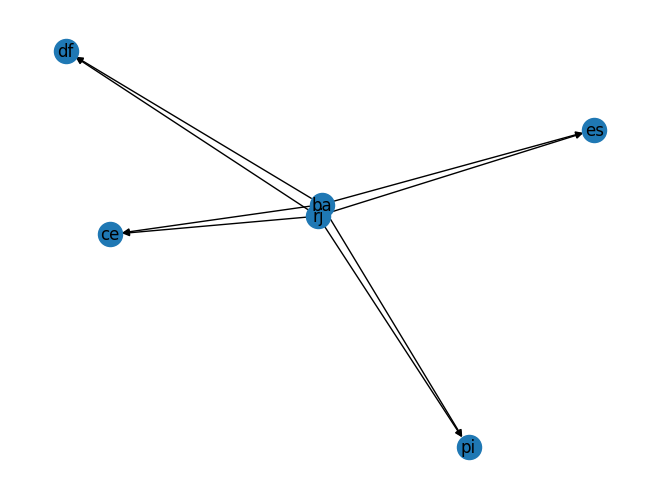

In [13]:
plot_edges(df_bitrate)

### Full serie - bit rate

<Axes: xlabel='timestamp'>

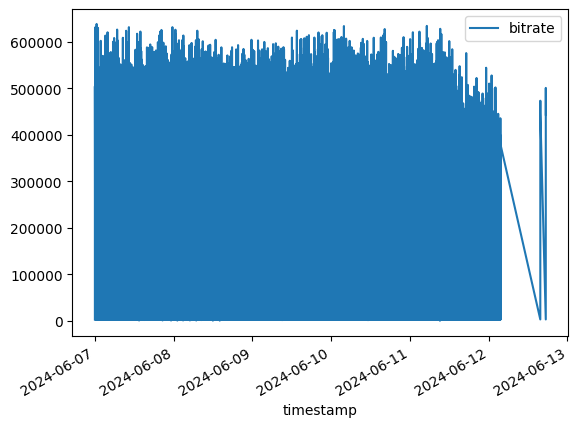

In [14]:
df_bitrate.plot(x = 'timestamp', y='bitrate')

### Full serie - 60 minutes

<Axes: xlabel='timestamp', ylabel='bitrate'>

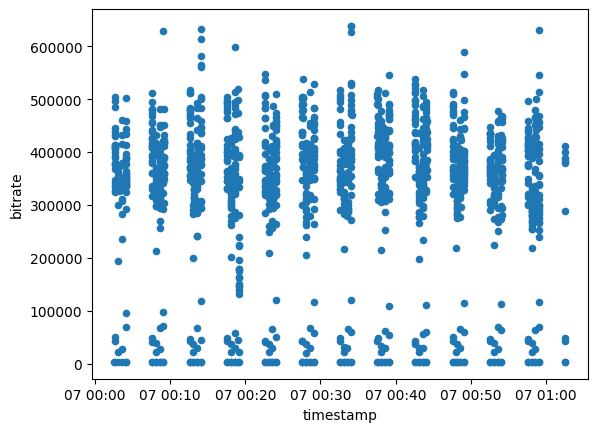

In [15]:
filter_interval(
    df = df_bitrate,
    minutes = 60
).plot.scatter(x='timestamp', y='bitrate')

### Bitrate scatter plot by network edge (client-server pair)

<Axes: xlabel='timestamp', ylabel='bitrate'>

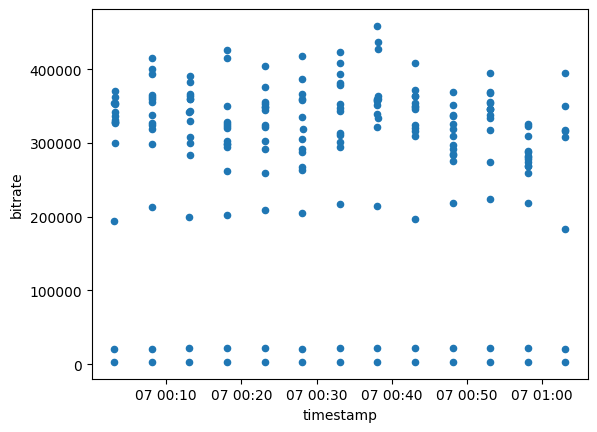

In [60]:
df_bitrate_rj_pi = df_bitrate.loc[df_bitrate['edge'] == 'rj-pi']

filter_interval(
    df = df_bitrate_rj_pi,
    minutes = 60
).plot.scatter(x='timestamp', y='bitrate')

<Axes: xlabel='timestamp', ylabel='bitrate'>

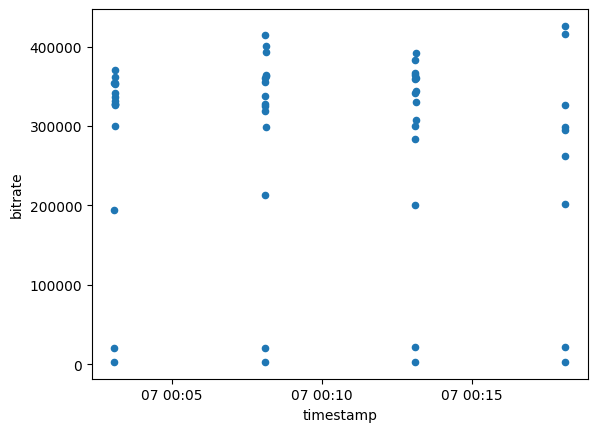

In [17]:
filter_interval(
    df = df_bitrate_rj_pi,
    minutes = 15
).plot.scatter(x='timestamp', y='bitrate')

Each 15 entries form a group of one measure

In [18]:
df_grouped = group_by_timestamp(df_bitrate_rj_pi)
df_grouped['mean'] = df_grouped['values'].apply(lambda x: np.mean(x))
df_grouped

,timestamp,values,mean
0,2024-06-07 00:03:06,"[21075, 3000, 194814, 354496, 331514, 328336, ...",282443.500000
1,2024-06-07 00:08:06,"[21006, 3000, 327178, 414737, 337786, 318897, ...",285691.133333
2,2024-06-07 00:13:05,"[21453, 200181, 341886, 359307, 363754, 382699...",290321.333333
3,2024-06-07 00:18:05,"[21605, 326138, 201663, 299070, 294464, 262057...",299673.666667
4,2024-06-07 00:23:05,"[209287, 21228, 3000, 259771, 322157, 352665, ...",290678.133333
...,...,...,...
1472,2024-06-12 03:18:06,"[206689, 21014, 3000, 268417, 346525, 377392, ...",260561.666667
1473,2024-06-12 03:23:06,"[191072, 288663, 3000, 315580, 353283, 290715,...",300792.733333
1474,2024-06-12 03:28:06,"[21283, 190278, 369101, 309949, 255484, 368880...",290014.266667
1475,2024-06-12 03:33:06,"[21155, 192645, 351863, 396366, 333048, 409673...",296802.666667


<Figure size 640x480 with 0 Axes>

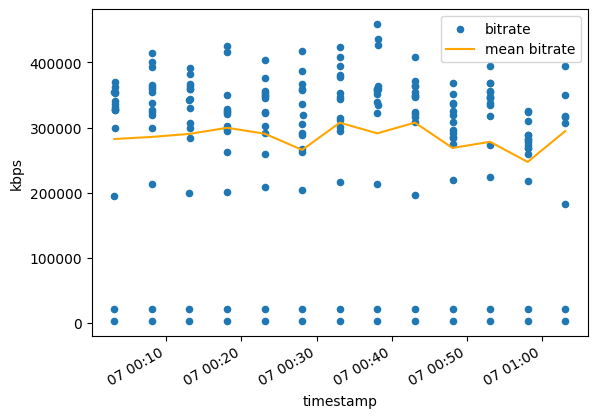

In [19]:
plt.figure()
ax = filter_interval(df = df_bitrate_rj_pi).plot(kind="scatter", x="timestamp",y="bitrate", label="bitrate")
filter_interval(df = df_grouped).plot(x="timestamp",y="mean", color="orange", label="mean bitrate", ax=ax)

ax.set_xlabel("timestamp")
ax.set_ylabel("kbps")
plt.show()

## RTT

In [20]:
df_rtt = pd.read_csv("dataset/rtt_train.csv")

In [21]:
df_rtt.describe()

,timestamp,rtt
count,1.090100e+04,10901.000000
mean,1.717939e+09,22.592836
std,1.341971e+05,12.549167
min,1.717719e+09,6.879000
25%,1.717821e+09,12.510000
50%,1.717937e+09,19.530000
75%,1.718051e+09,31.100000
max,1.718213e+09,177.800000


In [22]:
df_rtt.head()

,client,server,timestamp,rtt
0,ba,ce,1717718941,12.52
1,ba,ce,1717719217,12.59
2,ba,ce,1717719722,12.49
3,ba,ce,1717719841,12.49
4,ba,ce,1717720185,12.48


In [23]:
df_rtt["timestamp"] = pd.to_datetime(df_rtt["timestamp"], unit="s")
df_rtt.index = df_rtt["timestamp"]
df_rtt.sort_index(inplace=True)
df_rtt.head()


print(f"star at: {df_rtt.index.min()}")
print(f"end at: {df_rtt.index.max()}")

star at: 2024-06-07 00:02:37
end at: 2024-06-12 17:19:34


In [24]:
df_rtt["edge"] = df_rtt["client"] + "-" + df_rtt["server"]
df_rtt["edge"].value_counts()

edge
ba-ce    1492
rj-ce    1487
ba-pi    1361
ba-df    1347
rj-df    1339
rj-pi    1330
ba-es    1283
rj-es    1262
Name: count, dtype: int64

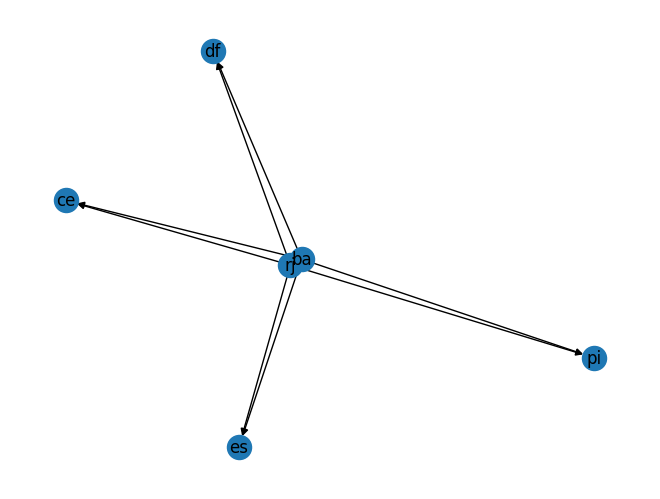

In [25]:
plot_edges(df_rtt)


<Axes: xlabel='timestamp'>

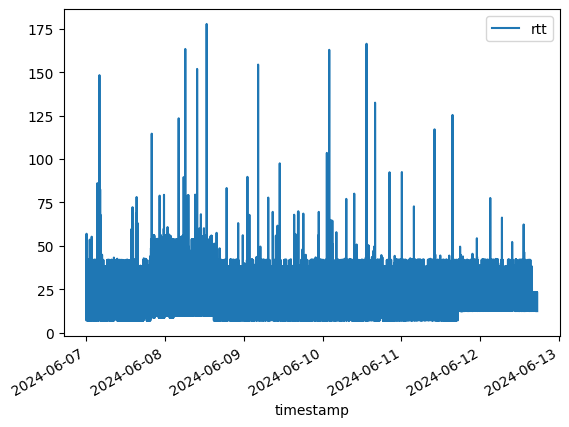

In [26]:
df_rtt.plot(x="timestamp", y="rtt")

<Axes: xlabel='timestamp', ylabel='rtt'>

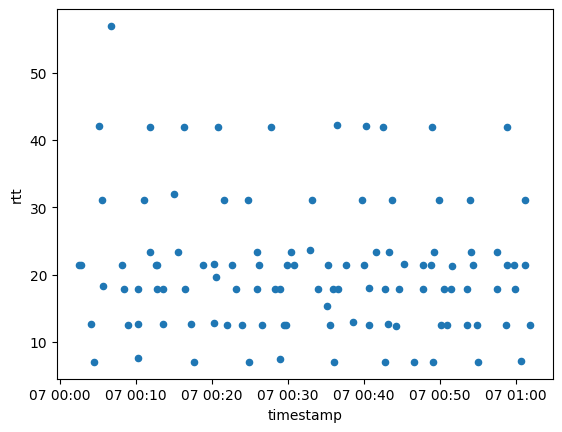

In [27]:
filter_interval(df=df_rtt, minutes=60).plot.scatter(x="timestamp", y="rtt")

In [28]:
pi_rj = df_rtt.loc[df_rtt["edge"] == "rj-pi"]

<Axes: xlabel='timestamp', ylabel='rtt'>

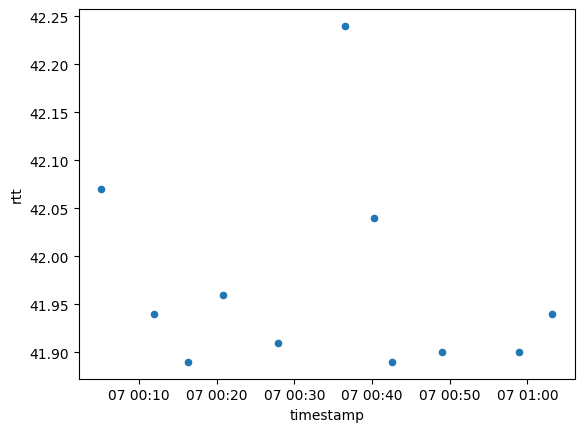

In [29]:
filter_interval(df=pi_rj, minutes=60).plot.scatter(x="timestamp", y="rtt")

<Axes: xlabel='timestamp', ylabel='rtt'>

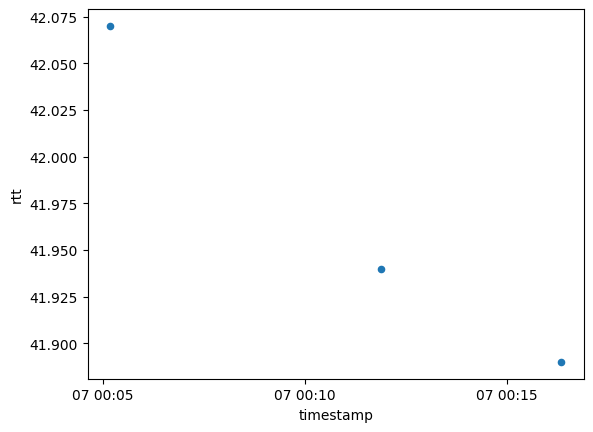

In [30]:
filter_interval(df=pi_rj, minutes=15).plot.scatter(x="timestamp", y="rtt")

In [31]:
# dont make sense rtt by timestamp because its a single measure and not a group of measures
# df_grouped = group_by_timestamp(df_rtt)
# df_grouped["mean"] = df_grouped["values"].apply(lambda x: np.mean(x))
# df_grouped

In [32]:
%pip install ipywidgets


Note: you may need to restart the kernel to use updated packages.


In [33]:
import ipywidgets as widgets


In [34]:
minutes = widgets.IntSlider(value=60, min=15, max=600, step=15)
minutes

IntSlider(value=60, max=600, min=15, step=15)

<Figure size 640x480 with 0 Axes>

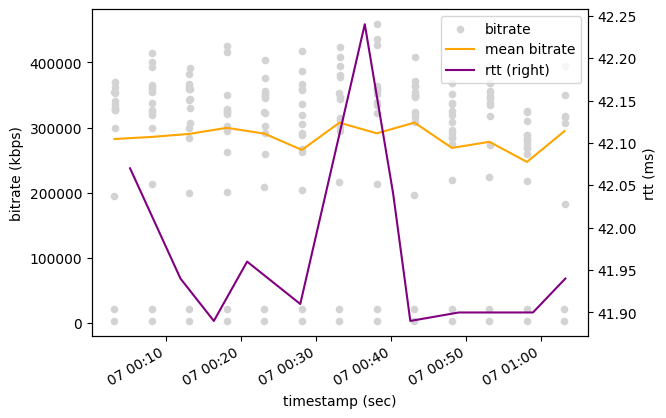

In [35]:
interval = minutes.value

plt.figure()
ax = filter_interval(df=df_bitrate_rj_pi, minutes = interval).plot(
    kind="scatter", x="timestamp", y="bitrate", label="bitrate", color='lightgray'
)

filter_interval(df=df_grouped, minutes = interval).plot(
    x="timestamp", y="mean", color="orange", label="mean bitrate", ax=ax
)

ax2 = filter_interval(df=pi_rj, minutes = interval).plot(
    x="timestamp", y="rtt", color="purple", label="rtt", ax=ax, secondary_y=True
)

ax.set_xlabel("timestamp (sec)")
ax.set_ylabel("bitrate (kbps)")
ax2.set_ylabel('rtt (ms)')
plt.show()



## What is a network problem

We have different performances of the network given the distance between the client and the server, data needs to travel in a physical medium, so physics applies.

From the data we observed that the mean Round Trip Time (RTT) for the edge between Rio de Janeiro and Piaui is 42 miliseconds, and the standard deviation is of about 6 miliseconds.

So we will split our range of values in two sections:  
* Good: when `rtt <= mean + std`. 
* Bad: when `rtt > mean + std`. 

The good range is when RTT lest or equal to 48 miliseconds, and bad when greater than 48 miliseconds.

This approach of tracking latency in terms of standard deviation could be useful to ensure a steady quality of service.

In [36]:
pi_rj.describe()

,timestamp,rtt
count,1330,1330.000000
mean,2024-06-09 18:39:28.446616576,42.737850
min,2024-06-07 00:05:11,38.020000
25%,2024-06-08 09:26:09.249999872,38.270000
50%,2024-06-09 18:31:32,41.910000
75%,2024-06-11 03:27:58.750000128,42.020000
max,2024-06-12 15:40:14,92.500000
std,NaN,5.987561


### RTT by Edge

/tmp/ipykernel_138288/1405386417.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_rtt[['edge','rtt']].hist(bins=50, by='edge',ax = ax)


array([[<Axes: title={'center': 'ba-ce'}>,
        <Axes: title={'center': 'ba-df'}>,
        <Axes: title={'center': 'ba-es'}>],
       [<Axes: title={'center': 'ba-pi'}>,
        <Axes: title={'center': 'rj-ce'}>,
        <Axes: title={'center': 'rj-df'}>],
       [<Axes: title={'center': 'rj-es'}>,
        <Axes: title={'center': 'rj-pi'}>, <Axes: >]], dtype=object)

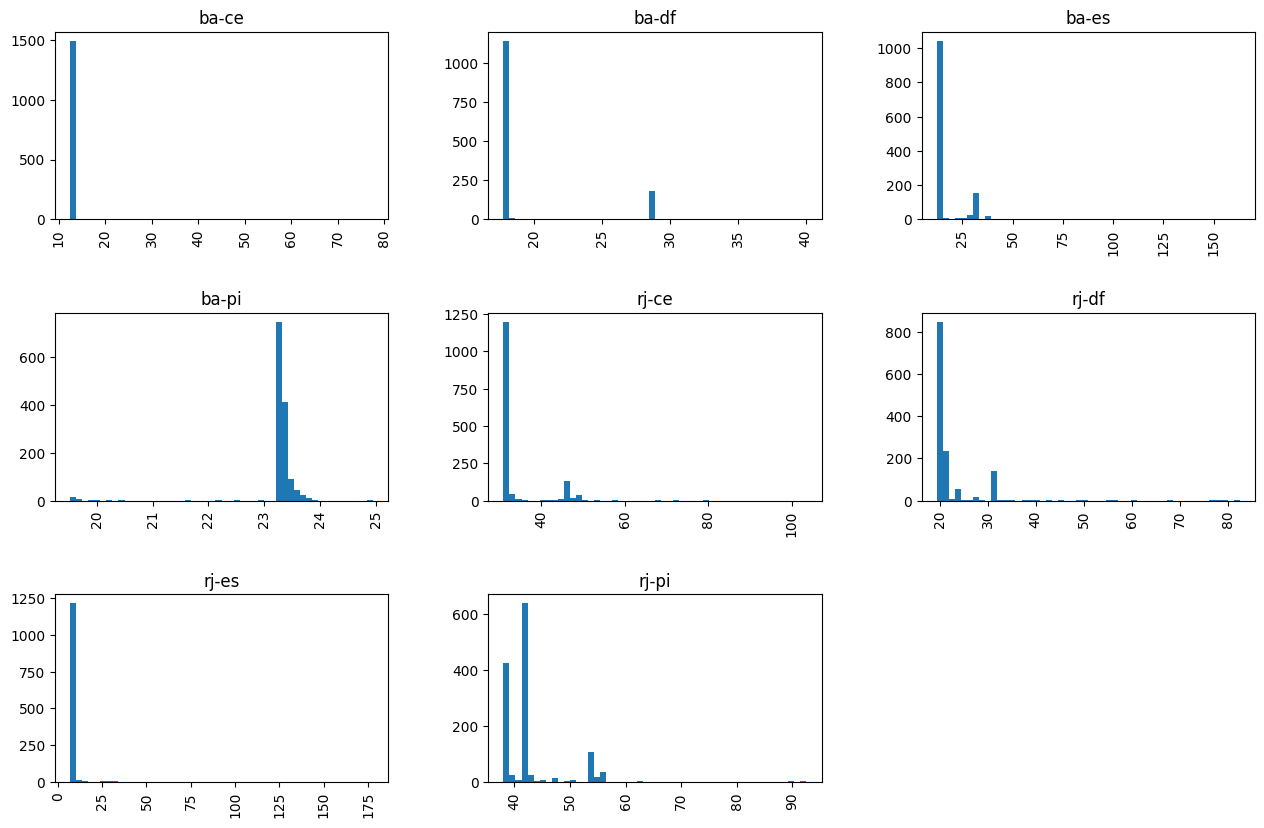

In [37]:
fig = plt.figure(figsize = (15,10))
ax = fig.gca()
df_rtt[['edge','rtt']].hist(bins=50, by='edge',ax = ax)

### Bitrate by Edge

In [38]:
df_bitrate

,client,server,timestamp,bitrate,edge
timestamp,,,,,
2024-06-07 00:02:35,ba,df,2024-06-07 00:02:35,3000,ba-df
2024-06-07 00:02:36,rj,df,2024-06-07 00:02:36,323984,rj-df
2024-06-07 00:02:36,ba,df,2024-06-07 00:02:36,347367,ba-df
2024-06-07 00:02:36,ba,df,2024-06-07 00:02:36,327273,ba-df
2024-06-07 00:02:36,ba,df,2024-06-07 00:02:36,413041,ba-df
...,...,...,...,...,...
2024-06-12 17:23:37,ba,ce,2024-06-12 17:23:37,413641,ba-ce
2024-06-12 17:23:37,ba,ce,2024-06-12 17:23:37,391200,ba-ce
2024-06-12 17:23:37,ba,ce,2024-06-12 17:23:37,439993,ba-ce


/tmp/ipykernel_138288/3776102139.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_bitrate[['edge','bitrate']].hist(bins=50, by='edge',ax = ax)


array([[<Axes: title={'center': 'ba-ce'}>,
        <Axes: title={'center': 'ba-df'}>,
        <Axes: title={'center': 'ba-es'}>],
       [<Axes: title={'center': 'ba-pi'}>,
        <Axes: title={'center': 'rj-ce'}>,
        <Axes: title={'center': 'rj-df'}>],
       [<Axes: title={'center': 'rj-es'}>,
        <Axes: title={'center': 'rj-pi'}>, <Axes: >]], dtype=object)

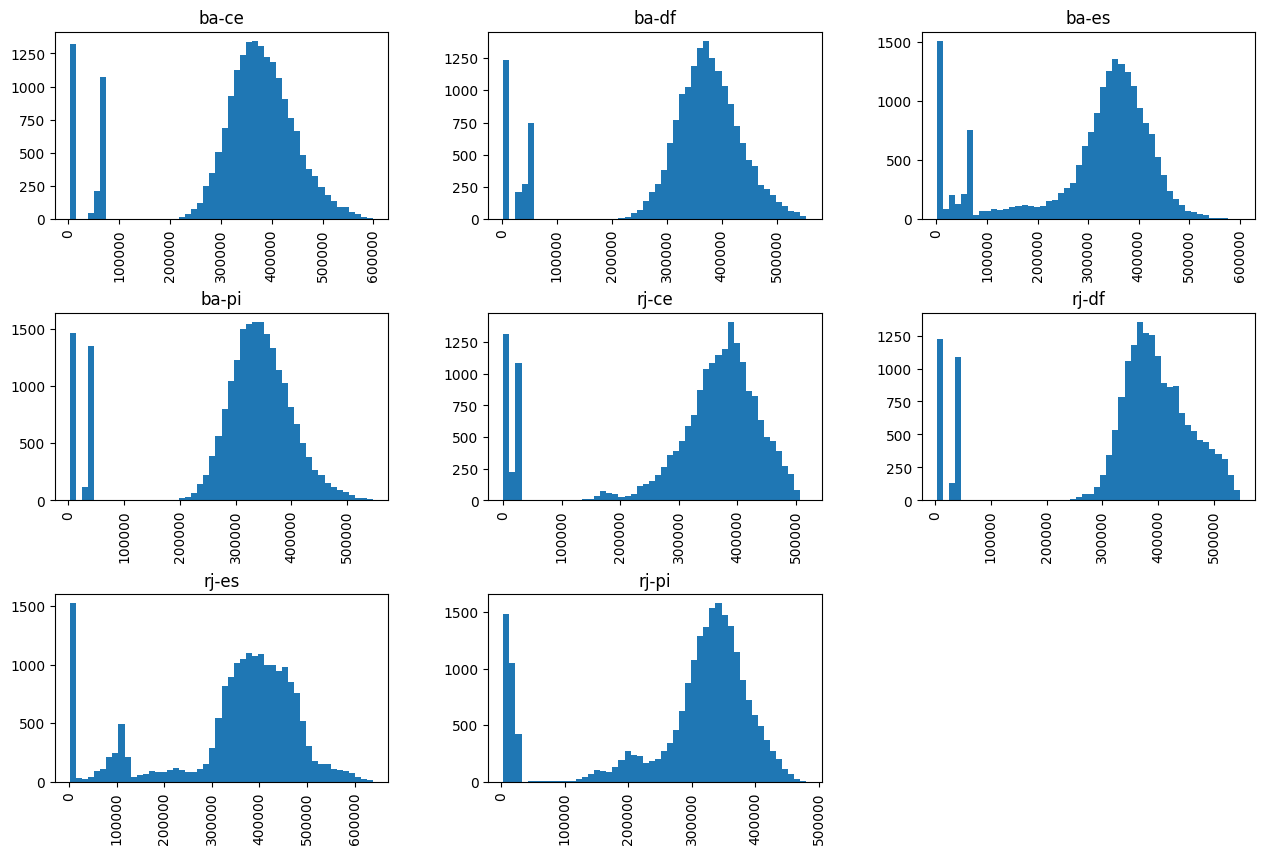

In [39]:
fig = plt.figure(figsize = (15,10))
ax = fig.gca()
df_bitrate[['edge','bitrate']].hist(bins=50, by='edge',ax = ax)

### -

In [40]:
mean = pi_rj['rtt'].mean()
std = pi_rj['rtt'].std()
rtt_threshold = mean + 2 * std
pi_rj.loc[pi_rj['rtt'] > rtt_threshold]

,client,server,timestamp,rtt,edge
timestamp,,,,,
2024-06-07 01:40:41,rj,pi,2024-06-07 01:40:41,55.27,rj-pi
2024-06-07 15:10:41,rj,pi,2024-06-07 15:10:41,68.89,rj-pi
2024-06-07 15:41:38,rj,pi,2024-06-07 15:41:38,63.04,rj-pi
2024-06-07 20:28:01,rj,pi,2024-06-07 20:28:01,56.13,rj-pi
2024-06-07 20:33:01,rj,pi,2024-06-07 20:33:01,56.25,rj-pi
...,...,...,...,...,...
2024-06-10 04:10:16,rj,pi,2024-06-10 04:10:16,57.87,rj-pi
2024-06-10 09:36:46,rj,pi,2024-06-10 09:36:46,80.06,rj-pi
2024-06-10 20:21:47,rj,pi,2024-06-10 20:21:47,92.38,rj-pi


## QoE

In [41]:
# # NOTE: a estrategia de agrupar bitrate e rtt quando as medições ocorrem ao mesmo tempo deixa muito poucos dados por edge
bitrate_ts = set(df_bitrate['timestamp'])
rtt_ts = set(df_rtt['timestamp'])
common_ts = rtt_ts.union(bitrate_ts)
df_rtt = df_rtt.loc[df_rtt['timestamp'].isin(common_ts)].reset_index(drop=True)
df_bitrate = df_bitrate.loc[df_bitrate['timestamp'].isin(common_ts)].reset_index(drop=True)

31028

In [44]:
df = pd.merge(df_rtt, df_bitrate, on=['timestamp','edge'])
df

,client_x,server_x,timestamp,rtt,edge,client_y,server_y,bitrate
0,rj,df,2024-06-07 00:02:37,21.44,rj-df,rj,df,334608
1,rj,df,2024-06-07 00:02:37,21.44,rj-df,rj,df,445348
2,rj,df,2024-06-07 00:02:37,21.44,rj-df,rj,df,408050
3,rj,df,2024-06-07 00:02:37,21.44,rj-df,rj,df,496041
4,rj,df,2024-06-07 00:02:37,21.44,rj-df,rj,df,375844
...,...,...,...,...,...,...,...,...
594,ba,pi,2024-06-11 19:48:07,23.41,ba-pi,ba,pi,305646
595,rj,pi,2024-06-12 02:08:08,41.99,rj-pi,rj,pi,364162
596,rj,pi,2024-06-12 02:08:08,41.99,rj-pi,rj,pi,406295
597,rj,pi,2024-06-12 02:08:08,41.99,rj-pi,rj,pi,388668


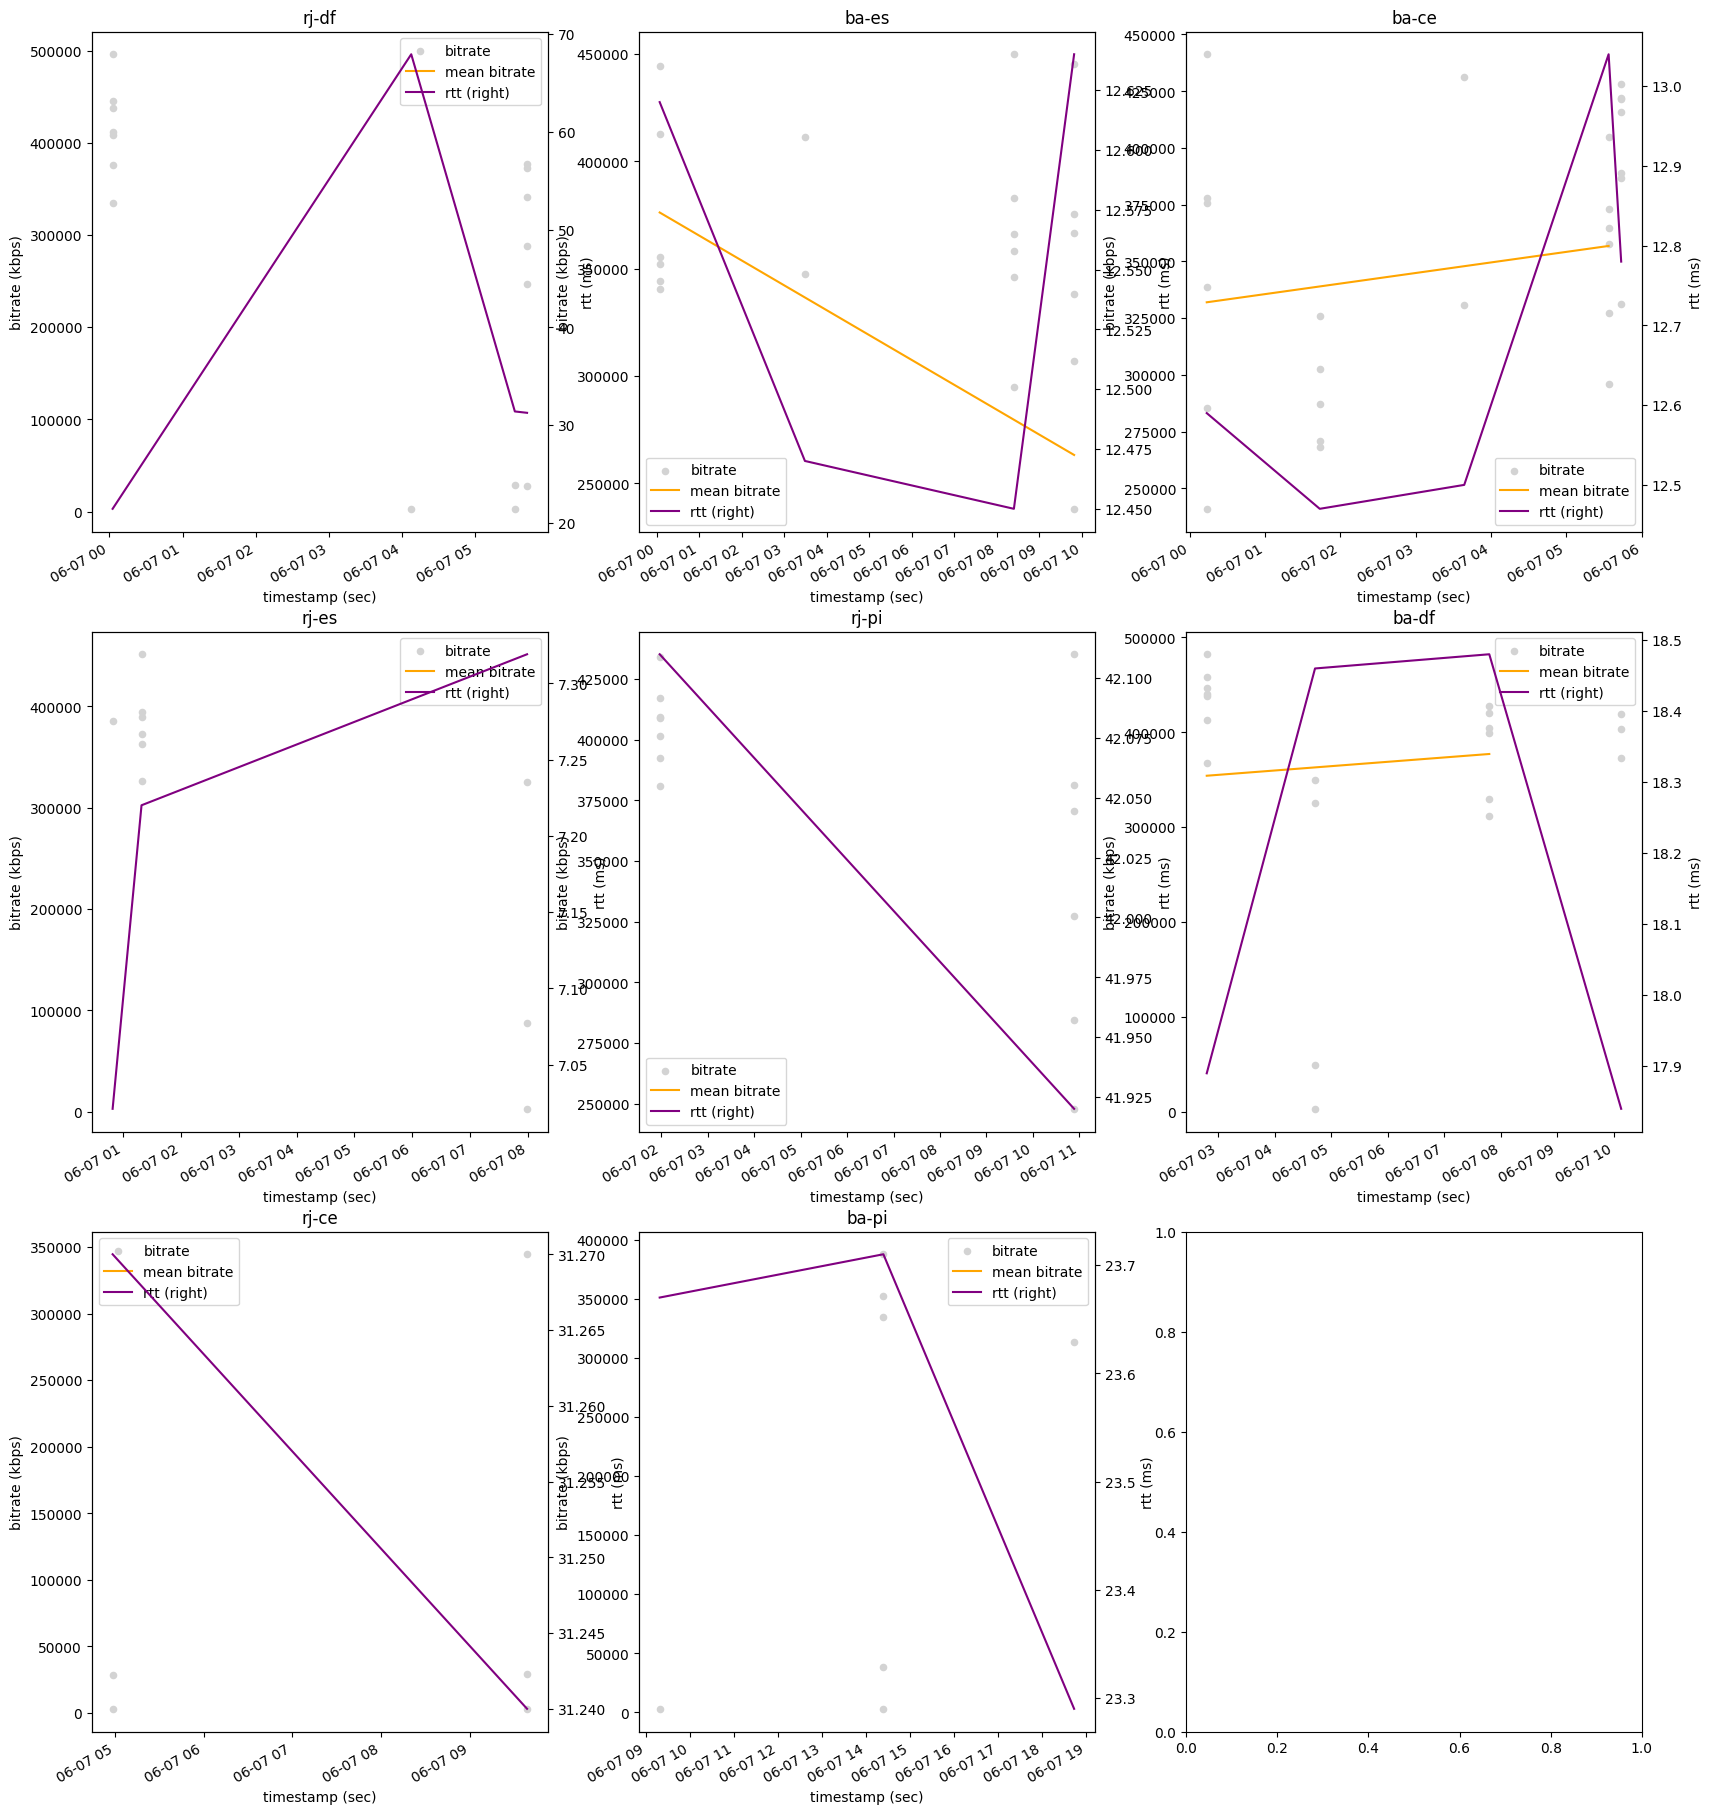

In [59]:
minute = 1
hour = 60
day = 24 * hour

import matplotlib.pyplot as plt
figure, axis = plt.subplots(3, 3, figsize=(20,25))


# bitrate individual measures
interval = 10 * hour
edges = df['edge'].unique()

width = 3
height = 3
row_idx = 0
col_idx = 0




for edge in edges:
    df_edge = df.loc[df['edge'] == edge]
    df_grouped = group_by_timestamp(df_edge)
    df_grouped['mean'] = df_grouped['values'].apply(lambda x: np.mean(x))
    

    ax = filter_interval(df_edge, minutes= interval).plot(
        kind="scatter",
        x="timestamp", 
        y="bitrate", 
        label="bitrate", 
        color='lightgray',
        ax = axis[row_idx, col_idx]
    )

    
    filter_interval(df_grouped, minutes=interval).plot(
        x="timestamp",
        y="mean",
        color="orange", 
        label="mean bitrate", 
        ax=axis[row_idx, col_idx]
    )

    ax2 = filter_interval(df_edge, minutes= interval).plot(
        x="timestamp", 
        y="rtt", 
        color="purple", 
        label="rtt", 
        secondary_y=True,
        ax=axis[row_idx, col_idx],
    )

    ax.set_title(edge)
    ax.set_xlabel("timestamp (sec)")
    ax.set_ylabel("bitrate (kbps)")
    ax2.set_ylabel('rtt (ms)')

    if col_idx == width -1:
        row_idx +=1
        col_idx = 0
    else:
        col_idx +=1

plt.show()

